# Description of file:

This file aims to display the differences in fractal dimension, as images of fractals are translated.
## Functions:

### `fractal_dimension(Z, threshold = 0.9)`:
This uses two arguments: `Z` = one of the normalised image, and `threshold` = the threhsold value for conversion from pixel intensities to binary arrays. This returns the coefficient of the graph in of Minkowski-Bouligand graph and `x` and `y` values (which are the log(s) and log(N(s)) from:

$$\ln[N(s)] = \textrm{ - Dimension}\: * \: \ln(s) + h(s) $$


### `translate(file_name, lr, ud)`:
Uses the `cv2.warpAffine()` to translate image, where `lr` and `ud`, represent the horizontal and vertical displacement respectively. The file labeled `file_name` is translated and the resultant image is saved using `filename`+`lr`+`ud`. 

### `multi_translations(image, x, y)`:  
Automate the translation of the images used in this project, and the use of the `box_counts()` method.

### `normalize(x, newRange=(0, 1))`:
Normalises the array `x`, between the ranges found in tuple `newRange`.


In [34]:
import scipy.misc
import numpy as np
from sklearn.linear_model import LinearRegression
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import csv
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import pyplot, transforms
import math

In [35]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 6]

In [38]:

def fractal_dimension(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z <= threshold)

    # Minimal dimension of image
    p = min(Z.shape)
    
    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))
    #print(n)
    
    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)
    sizes = list(sizes)
    sizes = sizes[1:]
    
    # Actual box counting with decreasing size
    counts = []
    
    sizes = np.array(sizes)
    
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)

    
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    x = np.log(sizes)
    y = np.log(counts)
    

    
    
    return -coeffs[0], x, y




In [39]:
def start(filename, pixel_threshold = 0.9):
    I = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    I = I/256
    
    
    coeff, x, y  = fractal_dimension(I, pixel_threshold)
    return coeff, x, y

### Transalting image and saving it to the directory.

In [40]:
def translate(file_name, lr, ud):
    ROOT = "./SelfSimilarFractals/"
    
    file_dir = ROOT + file_name
    
    img = cv2.imread(file_dir)
    num_rows, num_cols = img.shape[:2]
    
    translation_matrix = np.float32([ [1,0,lr], [0,1,ud] ])
    img_translation = cv2.warpAffine(img, translation_matrix, (num_cols, num_rows), borderValue=(255,255,255))
    
    new_path = ROOT + "translated/"+file_name[:-4]+ str(int(lr)) + "+" + str(int(ud)) + file_name[-4:]
    
    #plt.imshow(img_translation)
    cv2.imwrite(new_path, img_translation)
    return new_path
    
    

In [52]:
def multi_translations(image, x, y):
    # below we translate image 
    new_path = translate(image, x, y)
    # find fractal dimension of the translated image
    coeff, x, y = start(new_path)
    return coeff

#### The below code forms the translation axis (figure 3.3 in dissertation)
Places these transaltion in two global lists, `x` and `y`, representing the horizontal and verticle displacement

In [44]:
files = [ "GreatBritain.png",  "SierpinskiTriangleHD.png", "Douady_rabbitNew.png",  "JuliaSetNew.png", "irelandcoastNew.png"]
x= [0,1, -1 ,1 , -1, 1, 0,-1,0]
y = [0,1 ,-1 ,-1, 1, 0, 1, 0,-1]

x = list(np.array(x)*10)
x = x +list(np.array(x)*2)  + list(np.array(x)*3) + list(np.array(x)*4) + list(np.array(x)*5) + list(np.array(x)*6)+ list(np.array(x)*7) #+ list(np.array(x)*15) #+ list(np.array(x)*20)  
y = list(np.array(y)*10)
y = y +list(np.array(y)*2) + list(np.array(y)*3) + list(np.array(y)*4) + list(np.array(y)*5) + list(np.array(y)*6) + list(np.array(y)*7)#+ list(np.array(y)*15) #+ list(np.array(x)*20)   

In [45]:
def normalize(x, newRange=(0, 1)): #x is an array. Default range is between zero and one
    xmin, xmax = np.min(x), np.max(x) #get max and min from input array
    norm = (x - xmin)/(xmax - xmin) # scale between zero and one
    
    if newRange == (0, 1):
        return(norm) # wanted range is the same as norm
    elif newRange != (0, 1):
        return norm * (newRange[1] - newRange[0]) + newRange[0] #scale to a different range.    
    #add other conditions here. For example, an error message

## Below we translate the benchmark fractals and then find the normed difference 
### see the disseration for more information

In [46]:
s = {}
for file in files:
    s[file] = []

# s is a dictionray whos keys are the fractal images under investigation
    
for file in files:
    for idx in range(len(x)):
        # stores the fractal dimension for each of the translated images
        s[file].append(multi_translations(file, x[idx], y[idx])) 

for fractal in s.keys():
    init = s[fractal][0]
    for idx in range(len(s[fractal])):
        # finds the difference for the fractal dimensions for all translations
        s[fractal][idx] = abs(s[fractal][idx]-init)

for fractal in s.keys():
    # normalises the difference found previoulsy
    s[fractal] = list(normalize(s[fractal], (0,200)))

### Below we visualise the normed differences as depicted in figure 3.4

In [47]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [14, 6]

In [48]:
titles = ["Great Britain", "Sierpinski Triangle", "Douady Rabbit",  "Julia Set", "Coast of Ireland"]

IndexError: list index out of range

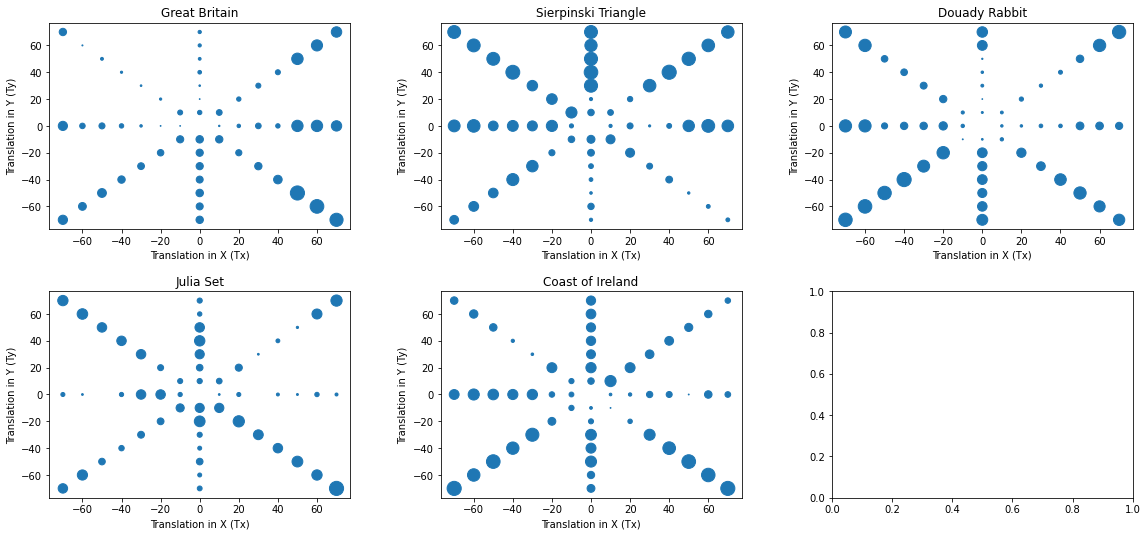

In [49]:
fig, axs = plt.subplots(2,3)
plt.subplots_adjust(left  = 0.125,  # the left side of the subplots of the figure
right = 1.2,    # the right side of the subplots of the figure
bottom = 0.1,   # the bottom of the subplots of the figure
top = 1.2 ,     # the top of the subplots of the figure
wspace = 0.3  , # the amount of width reserved for blank space between subplots
hspace = 0.3  ) # the amount of height reserved for white space between subplots
count = 0
for i in range(2):
    if count >= 5:
        break
    for j in range(3):
        #print(count)
        axs[i,j].scatter(x, y, s[list(s.keys())[count]])
        axs[i,j].title.set_text(list(s.keys())[count])
        axs[i,j].set_xlabel(xlabel = 'Translation in X (Tx)')
        axs[i,j].set_ylabel(ylabel = 'Translation in Y (Ty)')
        axs[i,j].title.set_text(titles[count])
        count +=1 



## Below we display the pixel density of each of the benchmark fractals

In [51]:
from PIL import Image

def get_num_pixels(filepath):
    width, height = Image.open(filepath).size
    return width*height, width , height
for i in files:
    print(i)
    print("pixel density is : {}".format(get_num_pixels("./SelfSimilarFractals/{}".format(i))[0]))
    print("pixel width is : {}".format(get_num_pixels("./SelfSimilarFractals/{}".format(i))[1]))
    print("pixel height is : {}".format(get_num_pixels("./SelfSimilarFractals/{}".format(i))[2]))

GreatBritain.png
pixel density is : 399424
pixel width is : 632
pixel height is : 632
SierpinskiTriangleHD.png
pixel density is : 2520000
pixel width is : 1800
pixel height is : 1400
Douady_rabbitNew.png
pixel density is : 2250000
pixel width is : 1500
pixel height is : 1500
JuliaSetNew.png
pixel density is : 1600000
pixel width is : 1600
pixel height is : 1000
irelandcoastNew.png
pixel density is : 6600000
pixel width is : 2200
pixel height is : 3000
